In [137]:
import torch
import skimage as sk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from torch_geometric.data import Data
from torch_geometric.transforms import ToSLIC
import torch
#torch transform bilinear interpolation
#torch transform resize
from torch.nn.functional import interpolate
from skimage.segmentation import slic
from skimage import graph as sk_graph
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.measure import regionprops
import networkx as nx
import torch_geometric as pyg
import skimage as sk
image_path = "/workspaces/masters_project/data/warcraft_shortest_path_oneskin/12x12/train_maps.npy"
label_path = "/workspaces/masters_project/data/warcraft_shortest_path_oneskin/12x12/train_shortest_paths.npy"
matrix_path = "/workspaces/masters_project/data/warcraft_shortest_path_oneskin/12x12/train_vertex_weights.npy" 

trial_index = 44
image = np.load(image_path)[trial_index]
label = np.load(label_path)[trial_index]


In [138]:
data_dir = "/workspaces/masters_project/data/warcraft_shortest_path_oneskin/12x12/"
data_suffix = "maps"
train_prefix = "train"


train_inputs = np.load(os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy"))
train_weights = np.load(os.path.join(data_dir, train_prefix + "_vertex_weights.npy"))
train_labels = np.load(os.path.join(data_dir, train_prefix + "_shortest_paths.npy"))

#images = train_inputs.transpose(0,2,3,1).astype(np.uint8)
images = train_inputs
idx = 44
im = images[idx]
label = train_labels[idx]
weights = train_weights[idx]

In [139]:

image = im
def path_to_graph(centroids, label, sensitivity=0.25,
                  resize_shape=(96, 96)):
    """"""
    label = sk.transform.resize(label, resize_shape)
    centroid_is_path = np.zeros(len(centroids)) # One-hot encoding if a centroid is part of the path or not
    centroid = centroids.numpy()

    for row in range(len(label)):
        for column in range(len(label)):
            if label[column, row] > np.max(label) - (sensitivity*np.max(label)): # Choose the 30% brightest spots on the label only
                dists = [np.linalg.norm([row, column] - c) for c in centroid] 

                centroid_is_path[np.argmin(dists)] = 1
    
    return torch.tensor(centroid_is_path)

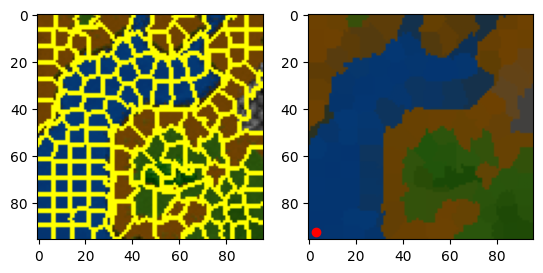

(91.3921568627451, 92.09803921568627)
(91.76470588235294, 80.20588235294117)
(92.27272727272727, 85.9090909090909)
(92.5, 3.0)
(92.5, 10.5)
(92.62745098039215, 18.784313725490197)
(93.15789473684211, 27.605263157894736)
(93.1025641025641, 66.87179487179488)
tensor([92.0980, 91.3922], dtype=torch.float64) tensor([115.]) tensor([31.6078, 74.4510,  6.9020], dtype=torch.float64)
tensor([80.2059, 91.7647], dtype=torch.float64) tensor([116.]) tensor([33.0882, 76.5882,  8.0588], dtype=torch.float64)
tensor([85.9091, 92.2727], dtype=torch.float64) tensor([117.]) tensor([30.7273, 74.4091,  7.0682], dtype=torch.float64)
tensor([ 3.0000, 92.5000], dtype=torch.float64) tensor([118.]) tensor([  4.3333,  52.9524, 112.6667], dtype=torch.float64)
tensor([10.5000, 92.5000], dtype=torch.float64) tensor([119.]) tensor([  4.2708,  53.0833, 112.6667], dtype=torch.float64)
tensor([18.7843, 92.6275], dtype=torch.float64) tensor([120.]) tensor([  4.3922,  54.9020, 114.5490], dtype=torch.float64)
tensor([27.60

In [140]:


def convert_image_to_graph(image, num_segments, label, compactness=10, sigma=0.0):
    """
    We have an image of size 12x12. We want to convert this into a graph
    where the nodes are the pixels. The edges are the pixels that are adjacent
    to each other. 
    
    The attribute of each node is a 3 dimensional vector,
    which is the RGB value of the pixel.
    """
    #first we need to create the nodes
    #the nodes are the pixels in the image
    segments = slic(image, n_segments=num_segments, compactness=compactness,
                     sigma=sigma,
                    enforce_connectivity=True)
    #this actually means that the centroids 
    new_image = np.zeros((96, 96, 3))

    unique_segments = np.unique(segments)
    for segment in unique_segments:
        indices = np.where(segments == segment)
        average_colour = np.mean(image[indices], axis=0)
        new_image[indices] = average_colour
    new_image = new_image / 255

    boundaries_test = find_boundaries(segments)
    boundaries = mark_boundaries(image, segments)

    #plot boundaries and new image side by side
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(boundaries)
    axs[1].imshow(new_image)
    #axs[1].scatter([92.5], [3], c="red")
    axs[1].scatter([3], [92.5], c="red")

    plt.show();
    rag = sk_graph.rag_mean_color(new_image, segments)
    regions = regionprops(segments)
    i = 0
    for region in regions:
        #currently we get (y, x ), changing to be (x, y)
#        coords = region['centroid']

 #       region['centroid'] = (coords[1], coords[0])
  #      print(region["centroid"])
        rag.nodes[region['label']]['centroid'] = region['centroid'][::-1]
        if i > 114:
            print(region['centroid'])

        i += 1
    graph = nx.Graph(rag)

    #graph = nx.Graph(graph_two)
    #convert graph_three to pytorch geometric
    #convert the graph to a torch geometric data object
    data = pyg.utils.from_networkx(graph)
    data.pixel_count = data["pixel count"]
    data.mean_color = data["mean color"]
    data.total_color = data["total color"] 
    data.edge_attr = data.weight
    data.labels = data.labels - 1.0

    #for testing:
    for i in range(data.labels.shape[0]):
        if i > 114:
            print(data.centroid[i], data.labels[i], 255*data.mean_color[i])
    
    #We can flip this here if we want
    data.centroid = data.centroid[:, [0, 1]]
   
    #change the 0th and 1th component of data['centroid]
    #data.centroid = [data.centroid[:1], data.centroid[:0]]
    #centroid_is_path = path_to_graph(data["centroid"], label)
    #data["centroid_in_path"] = centroid_is_path
    region_bc = boundaries
    axs[1].scatter(92.5, 3, s=100)
    data.centroid_in_path_raw =  path_to_graph(data["centroid"], label)
    return data, region_bc
    
data, bc = convert_image_to_graph(image, 200, label=label, compactness=10, sigma=0.0)

In [141]:
def bilinear_interpolation(image, nodes):
    values = []
    height, width = image.shape
    
    for node in nodes:
        x, y = node
        
        i, j = int(x), int(y)
        alpha, beta = x - i, y - j
        
        if i < 0 or i >= height - 1 or j < 0 or j >= width - 1:
            values.append(np.nan)  # Node outside the image bounds
        else:
            interpolated_value = (1 - alpha) * (1 - beta) * image[i, j] + \
                                 alpha * (1 - beta) * image[i + 1, j] + \
                                 (1 - alpha) * beta * image[i, j + 1] + \
                                 alpha * beta * image[i + 1, j + 1]
            values.append(interpolated_value)
    
    return values
def path_to_graph_two(graph, weight_image):
    graph.centroid = graph.centroid/95
    graph.centroid = graph.centroid * 11
    temp = np.round(data.centroid.numpy()).astype(int)
    values = weight_image[temp[:, 0], temp[:, 1]]
    
    #values = bilinear_interpolation(weight_image, graph.centroid)
    data.centroid_values = torch.tensor(values)
    distances = torch.norm(graph.centroid, dim=1)
    #find the index of the maximum distance
    target = torch.argmax(distances).item()
    x = data.centroid_values
    graph.x = x
    nx_graph = pyg.utils.to_networkx(graph)
    path = nx.shortest_path(nx_graph, source=0, target=target)

    # path is a set of integers, we want to create a tensor
    #where the path is 1 and the rest is 0 of size target
    #create a tensor of size target
    path_tensor = torch.zeros(data.centroid.shape[0])
    #set the path nodes to 1
    path_tensor[path] = 1
    path_tensor.unsqueeze(0)
    data.centroid_in_path = path_tensor
    return data
data = path_to_graph_two(data, weights)

Weights: image of weights
graph: object

In [142]:
del data["pixel count"]
del data["total color"]


In [143]:
data

Data(edge_index=[2, 682], labels=[123, 1], mean color=[123, 3], centroid=[123, 2], weight=[682], num_nodes=123, pixel_count=[123], mean_color=[123, 3], total_color=[123, 3], edge_attr=[682], centroid_in_path_raw=[123], centroid_values=[123], x=[123], centroid_in_path=[123])

In [144]:
# data.centroid = data.centroid/95
# data.centroid = data.centroid * 11

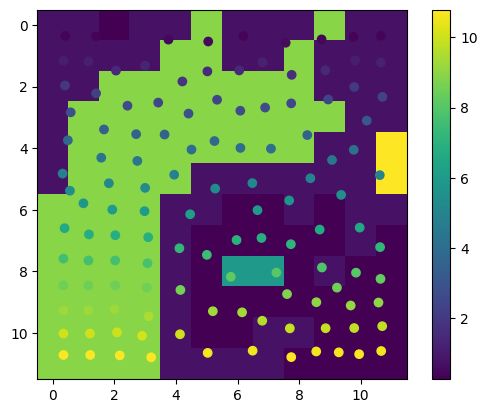

In [145]:
#plot the centroids
plt.imshow(weights, )

#plt.scatter(data.centroid[:, 0], data.centroid[:, 1])
#set the value displayed of centroid to be their y-coordinate
plt.scatter(data.centroid[:, 0], data.centroid[:, 1], c=data.centroid[:, 1])
plt.colorbar()

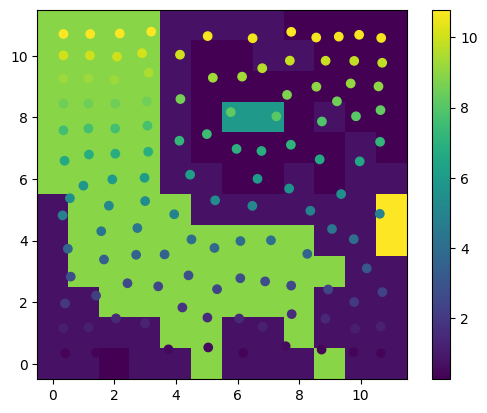

In [146]:
#plot the centroids
plt.imshow(weights, origin="lower" )

#plt.scatter(data.centroid[:, 0], data.centroid[:, 1])
#set the value displayed of centroid to be their y-coordinate
plt.scatter(data.centroid[:, 0], data.centroid[:, 1], c=data.centroid[:, 1],
            cmap="viridis")
plt.colorbar()

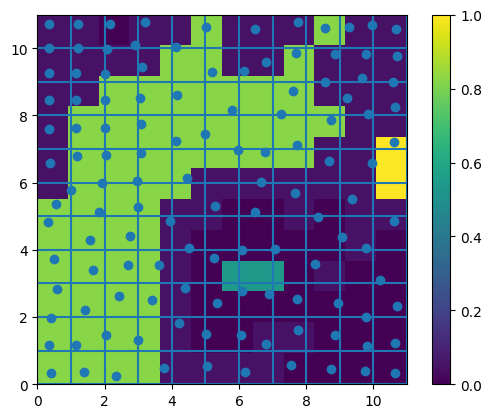

In [147]:
plt.imshow(weights, extent=[0, 11, 0, 11] )
#plot vertical and horizontal lines at every interval of 1
plt.vlines(np.arange(0, 12), ymin=0, ymax=11)
plt.hlines(np.arange(0, 12), xmin=0, xmax=11)
plt.scatter(data.centroid[:, 0], data.centroid[:, 1],
            )
plt.colorbar()

In [148]:
#get the max and min of the weights
print(np.max(weights), np.min(weights))

9.2 0.8


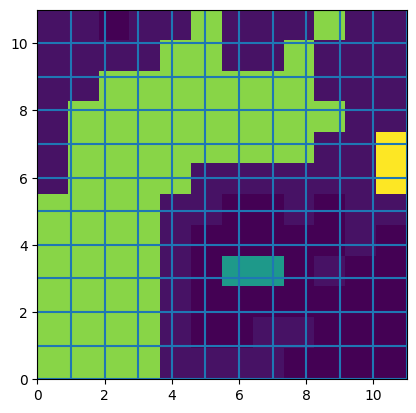

In [149]:
#find where each scatter point belongs to in the grid of image and then plot the weight
#of that point
plt.imshow(weights, extent=[0, 11, 0, 11] )
#plot vertical and horizontal lines at every interval of 1
plt.vlines(np.arange(0, 12), ymin=0, ymax=11)
plt.hlines(np.arange(0, 12), xmin=0, xmax=11)


In [150]:
temp = np.round(data.centroid.numpy()).astype(int)
#temp[:, 1] = weights.shape[0] - 1 - temp[:, 1]
#rotate the temp_weights by 90 degrees
#flip the y-axis
#temp_weights = weights[weights.shape[0] - 1 - temp[:, 1], temp[:, 0]]


In [151]:
temp = np.round(data.centroid.numpy()).astype(int)

colors = weights[temp[:, 0], temp[:, 1]]

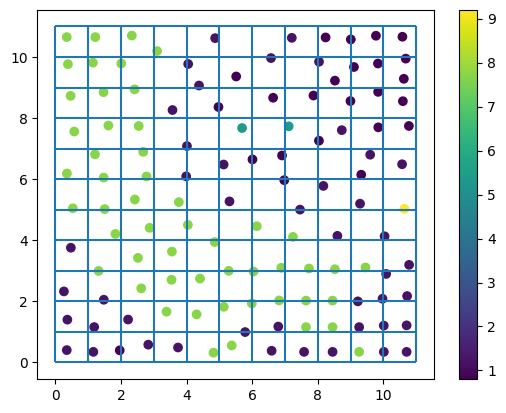

In [152]:
#plot the centroids with the weights as the color

#plt.imshow(weights, extent=[0, 11, 0, 11] )
#plot vertical and horizontal lines at every interval of 1

#plt.vlines(np.arange(0, 12), ymin=0, ymax=11)
#plt.hlines(np.arange(0, 12), xmin=0, xmax=11)
plt.scatter(data.centroid[:, 1], data.centroid[:, 0],
            c=colors, cmap="viridis")
#flip the y-axis
#flip the y-axis
#plt.gca().invert_yaxis()
plt.vlines(np.arange(0, 12), ymin=0, ymax=11)
plt.hlines(np.arange(0, 12), xmin=0, xmax=11)
plt.colorbar()

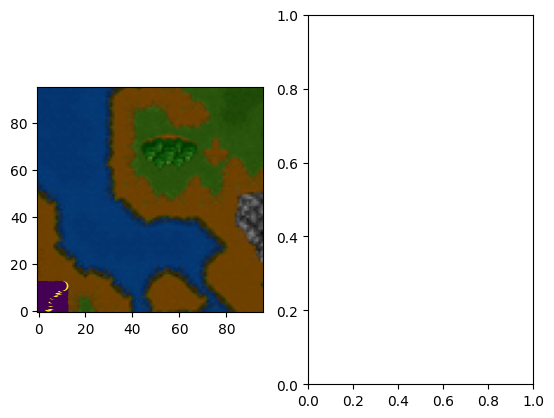

In [159]:
#shortest_path = path_to_graph_two(data, weights)
#plot the centroids with the weights as the color
#plt.imshow(weights, extent=[0, 11, 0, 11] )
fig, axs = plt.subplots(1,2)
axs[0].imshow(im, origin="lower")
axs[0].scatter(data.centroid[:, 0], data.centroid[:, 1], 
             c=data.centroid_in_path.numpy())


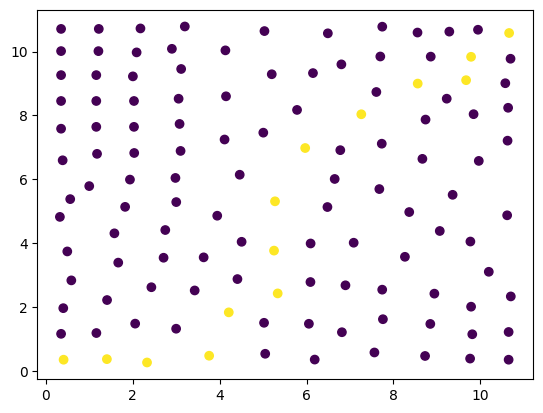

In [160]:
plt.scatter(data.centroid[:, 0], data.centroid[:, 1],
            c=data.centroid_in_path.numpy(), cmap="viridis")
#flip the y-axis
#flip the y-axis
#plt.gca().invert_yaxis()
#plot the centroids with the weights as the color


[]

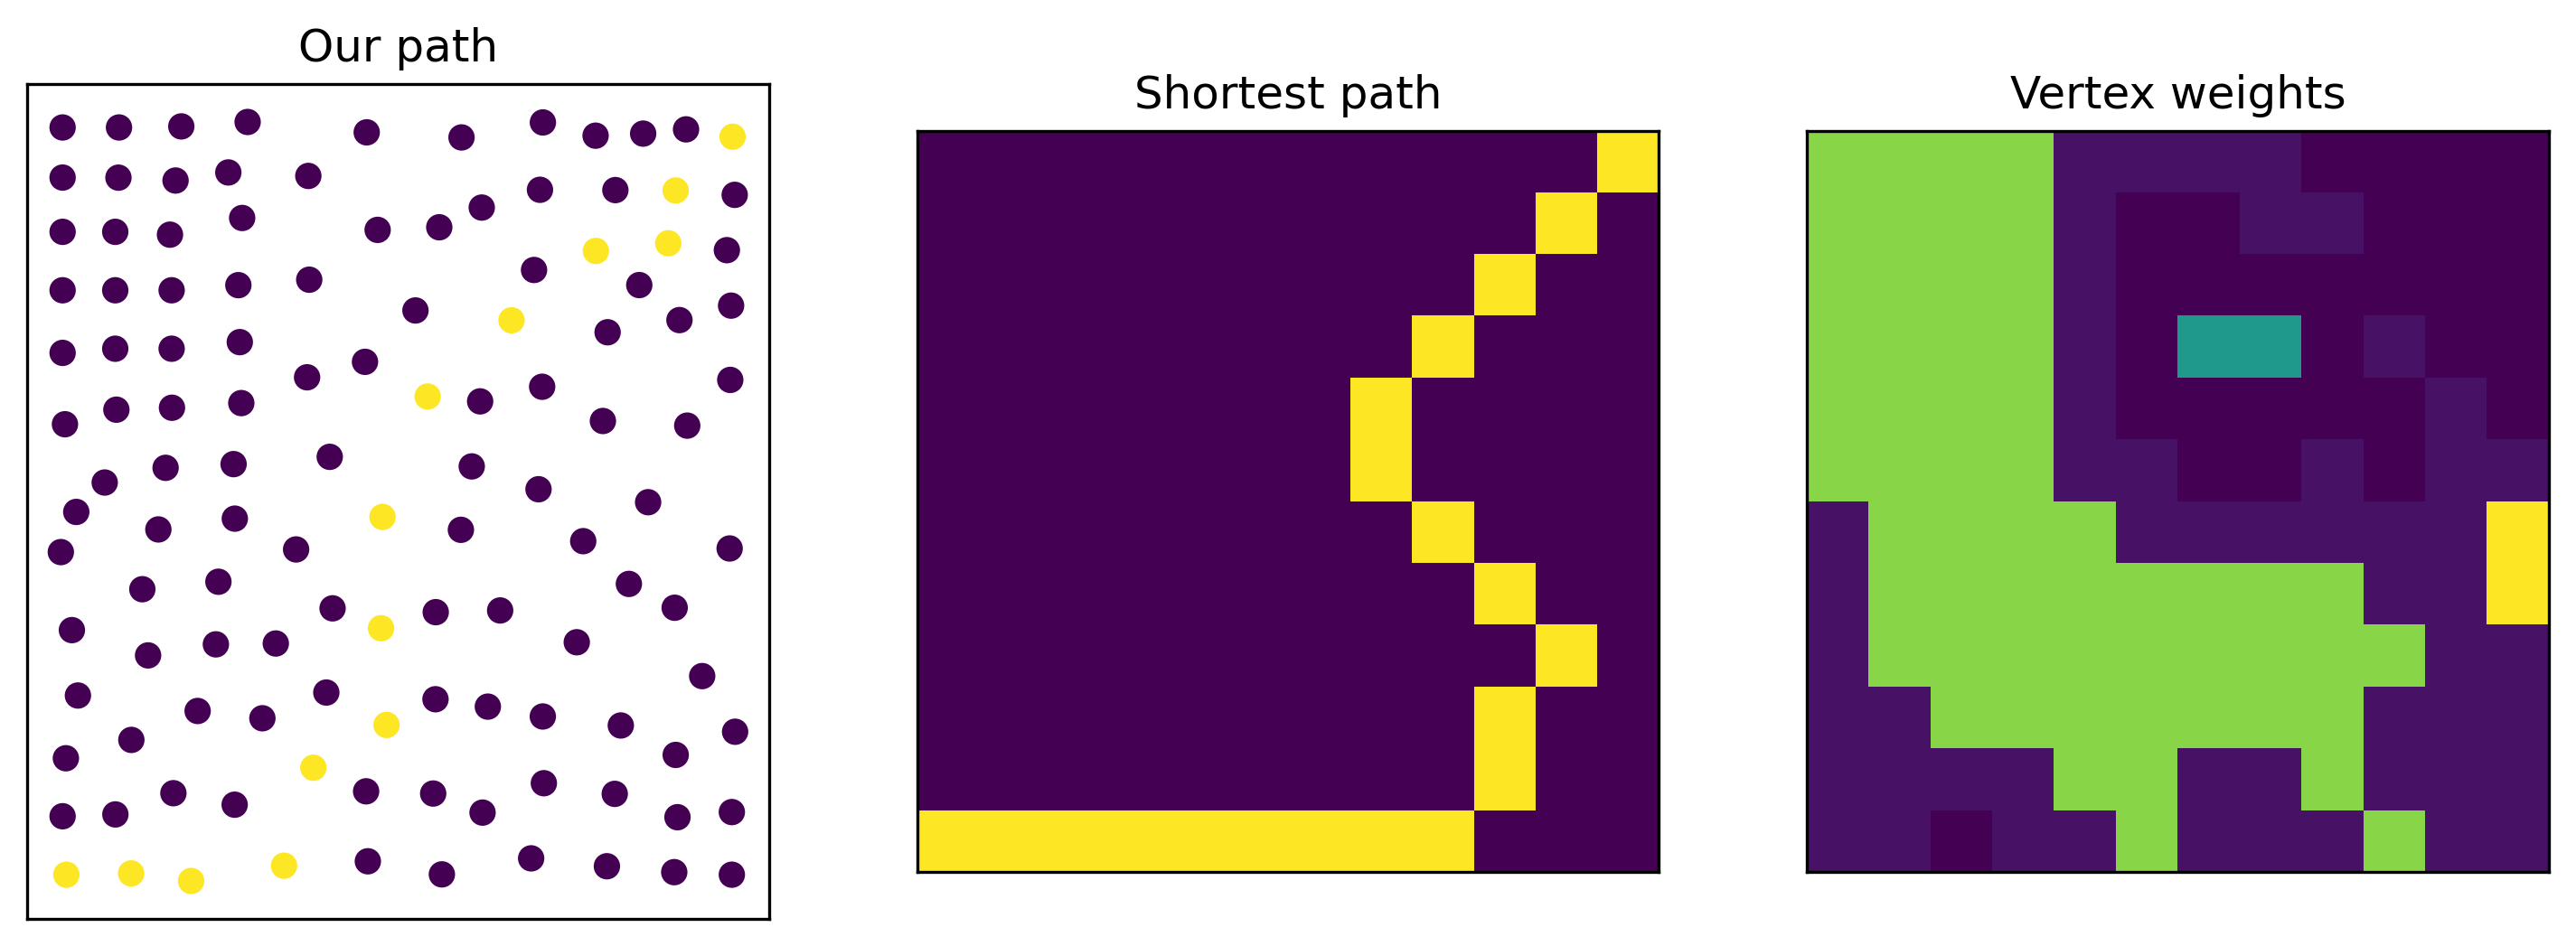

In [164]:
weights = train_weights[idx]
label = train_labels[idx]
label = train_labels[idx]

fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=300)

ax[0].scatter(data.centroid[:, 0], data.centroid[:, 1],
            c=data.centroid_in_path.numpy(), cmap="viridis")
#ax[0].invert_yaxis()
ax[0].set_title("Our path")
ax[1].imshow(label, origin="lower")
ax[1].set_title("Shortest path")
ax[2].set_title("Vertex weights")
ax[2].imshow(weights.astype(np.float32), origin="lower")

ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticks([])

Text(0.5, 1.0, 'Raw path')

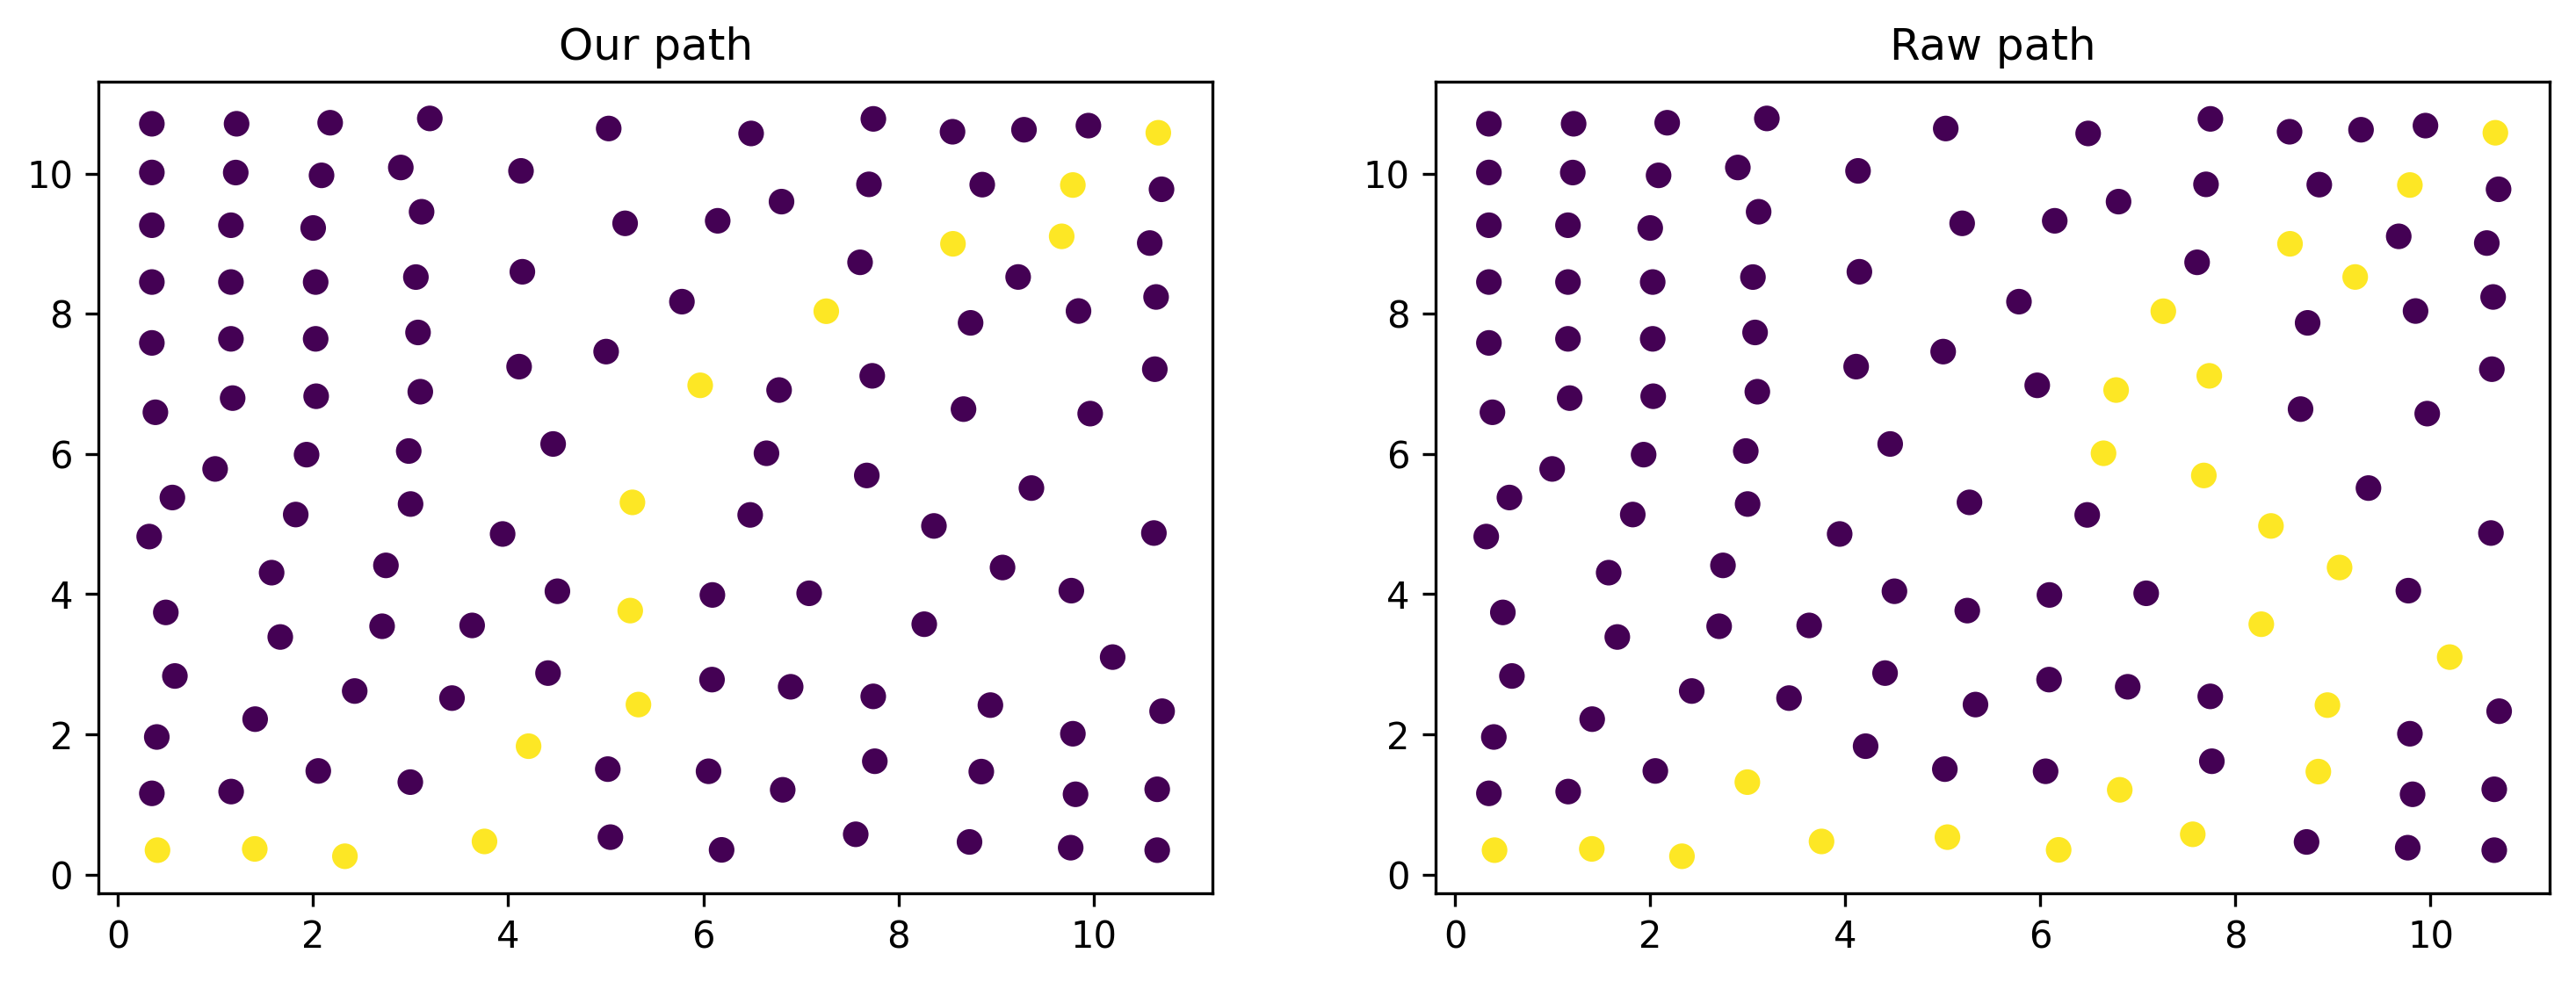

In [171]:
#plot the shortest path of our method and raw method side by sdie
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=300)

ax[0].scatter(data.centroid[:, 0], data.centroid[:, 1],
            c=data.centroid_in_path.numpy(), cmap="viridis")
#ax[0].invert_yaxis()
ax[0].set_title("Our path")

ax[1].scatter(data.centroid[:, 0], data.centroid[:, 1],
              c=data.centroid_in_path_raw.numpy(), cmap="viridis")
ax[1].set_title("Raw path")


#below each plot write the number of pixels in the path
#ax[0].text(0, -1, "Number of pixels in path: {}".format(int(torch.sum(data.centroid_in_path).item())))
#ax[1].text(0, -1, "Number of pixels in path: {}".format(int(torch.sum(data.centroid_in_path_raw).item())))


In [172]:
np.sum(label * weights)

27.7

In [176]:
print("Number of nodes in path: {}".format(int(torch.sum(data.centroid_in_path).item())))
print("Number of nodes in path: {}".format(int(torch.sum(data.centroid_in_path_raw).item())))

print("Weight of nodes in path: {}".format(torch.sum(data.centroid_in_path * data.centroid_values).item()))
print("Weight of nodes in path: {}".format(torch.sum(data.centroid_in_path_raw * data.centroid_values).item()))
print("Weight of image based path:", np.sum(label * weights))

Number of nodes in path: 14
Number of nodes in path: 24
Weight of nodes in path: 33.8974609375
Weight of nodes in path: 85.794921875
Weight of image based path: 27.7


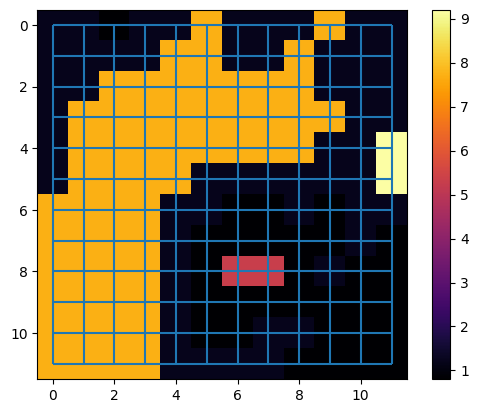

In [127]:
plt.imshow(weights,)
#plot vertical and horizontal lines at every interval of 1
plt.vlines(np.arange(0, 12), ymin=0, ymax=11)
plt.hlines(np.arange(0, 12), xmin=0, xmax=11)
plt.imshow(weights, cmap="inferno")

plt.colorbar()
#change the colormap to be something more visible


In [177]:
weights

array([[1.2, 1.2, 0.8, 1.2, 1.2, 7.7, 1.2, 1.2, 1.2, 7.7, 1.2, 1.2],
       [1.2, 1.2, 1.2, 1.2, 7.7, 7.7, 1.2, 1.2, 7.7, 1.2, 1.2, 1.2],
       [1.2, 1.2, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2],
       [1.2, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2],
       [1.2, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 9.2],
       [1.2, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 9.2],
       [7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 0.8, 0.8, 1.2, 0.8, 1.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 1.2, 0.8, 0.8, 0.8, 0.8, 0.8, 1.2, 0.8],
       [7.7, 7.7, 7.7, 7.7, 1.2, 0.8, 5.3, 5.3, 0.8, 1.2, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 1.2, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 1.2, 0.8, 0.8, 1.2, 1.2, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2, 1.2, 0.8, 0.8, 0.8, 0.8]],
      dtype=float16)

In [178]:
weights.shape

(12, 12)

In [179]:
weights[0][0]

1.2

In [180]:
our_path = data.centroid_in_path.numpy()
our_weight = np.sum(colors[our_path == 1])
our_weight

33.9